In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import seaborn as sns
import pandas as pd
import os
import numpy as np
import shap
import xgboost as xgb
current_directory = os.getcwd()
clinical_data_path = current_directory + r"\Epilepsy_clinical_data.xlsx"
clinical_data_df = pd.read_excel(clinical_data_path, sheet_name="All")
# strip ' from clinical_data_df.columns
clinical_data_df.columns = clinical_data_df.columns.str.strip("'")

def process_seizure_data(clinical_data):
    seizure_data = clinical_data.iloc[:clinical_data["Seizures type"].dropna().str.contains("TCS").shape[0]]
    seizure_df = pd.DataFrame(
        {
            "TonicClonicSeizures": seizure_data[seizure_data["Seizures type"].dropna().str.contains("TCS")]['# regions with BBBD'].reset_index(drop=True),
            "NonTonicClonicSeizures": seizure_data[~seizure_data["Seizures type"].dropna().str.contains("TCS")]['# regions with BBBD'].reset_index(drop=True),
        }
    )
    region_counts = clinical_data_df['# regions with BBBD'].dropna().astype(int).reset_index(drop=True)
    # All possible features
    feature_columns = ['Seizure Frequency (/m)', 'Number of medication','Age of oneset','Year of epilepsy', 'age','Lesion']
    feature_df = clinical_data_df[feature_columns].copy()
    # Convert 'Lesion' to 0,1
    feature_df.loc[:, 'Lesion'] = (feature_df['Lesion'] != 0).astype(int)
    # Convert 'Focal/General' to 'Focal' and 'General'
    feature_df.loc[:,'Focal'] = (clinical_data_df['Focal/General'] == 'F').astype(int)
    feature_df.loc[:,'General'] = (clinical_data_df['Focal/General'] == 'G').astype(int)
    seizure_df = pd.concat([seizure_df, feature_df], axis=1)
    # Drop na based on 'Number of medication' column
    seizure_df.dropna(subset=['Number of medication'], inplace=True)
    # Fill nan with median
    seizure_df.fillna(seizure_df.median(), inplace=True)
    return seizure_df, region_counts


Explained variance ratio for 1 components: 0.5105634669730468
Explained variance ratio for 2 components: 0.7066185401428444
Explained variance ratio for 3 components: 0.8324076644819182
Explained variance ratio for 4 components: 0.9478918184146219
Explained variance ratio for 5 components: 0.9989628999578647
Explained variance ratio for 6 components: 0.9997215623074117
Explained variance ratio for 7 components: 0.9998928278577569
Explained variance ratio for 8 components: 1.0
Explained variance ratio for 9 components: 1.0


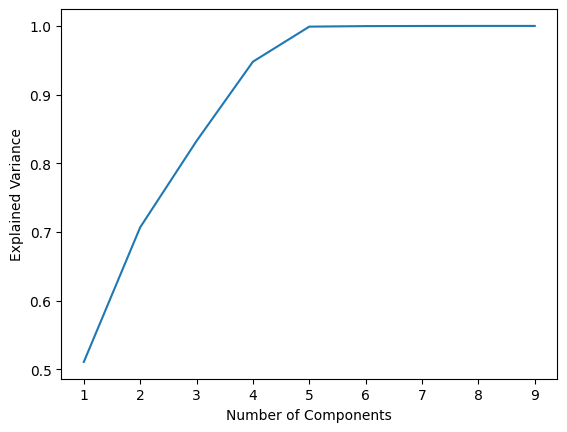

In [3]:
feature_df , number_of_regions= process_seizure_data(clinical_data_df)
def variance_per_component(feature_df):
    # Determine the number of columns in the DataFrame
    num_columns = feature_df.shape[1]
    # Initialize a list to store the explained variance ratios
    explained_variance_ratios = []
    # Loop over the range from 1 to the number of columns
    for i in range(1, num_columns):
        # Perform PCA with n_components set to the current number
        pca = PCA(n_components=i)
        X_pca = pca.fit_transform(feature_df)
        # Print the explained variance ratio
        explained_variance_ratio = sum(pca.explained_variance_ratio_)
        print(f'Explained variance ratio for {i} components: {explained_variance_ratio}')
        # Add the explained variance ratio to the list
        explained_variance_ratios.append(explained_variance_ratio)
    # Plot the explained variance ratios
    plt.plot(range(1, num_columns), explained_variance_ratios)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.show()
variance_per_component(feature_df)

PCA with 1 components:
Explained variance ratio: [0.51056347]


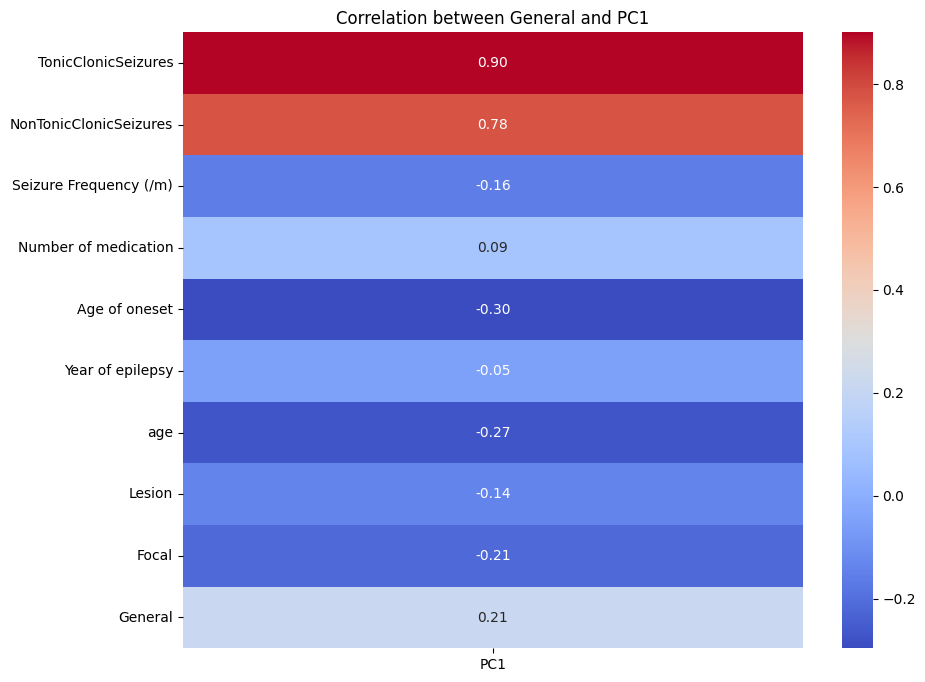

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
PCA with 2 components:
Explained variance ratio: [0.51056347 0.19605507]


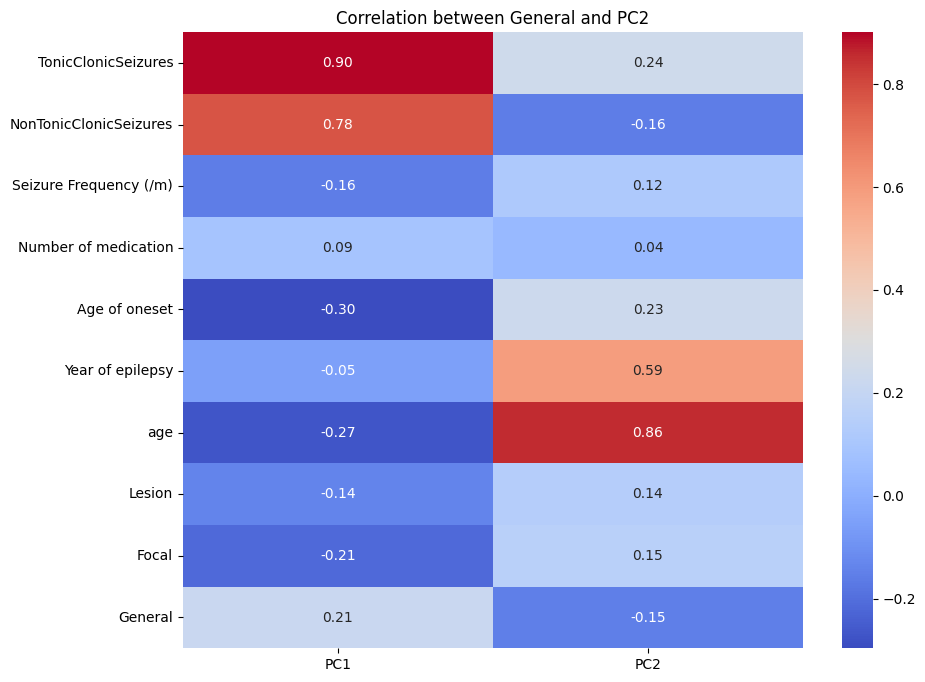

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
Correlation between PC2 and number of regions: 0.041216316633421596, p-value: 0.7762627149640793
PCA with 3 components:
Explained variance ratio: [0.51056347 0.19605507 0.12578912]


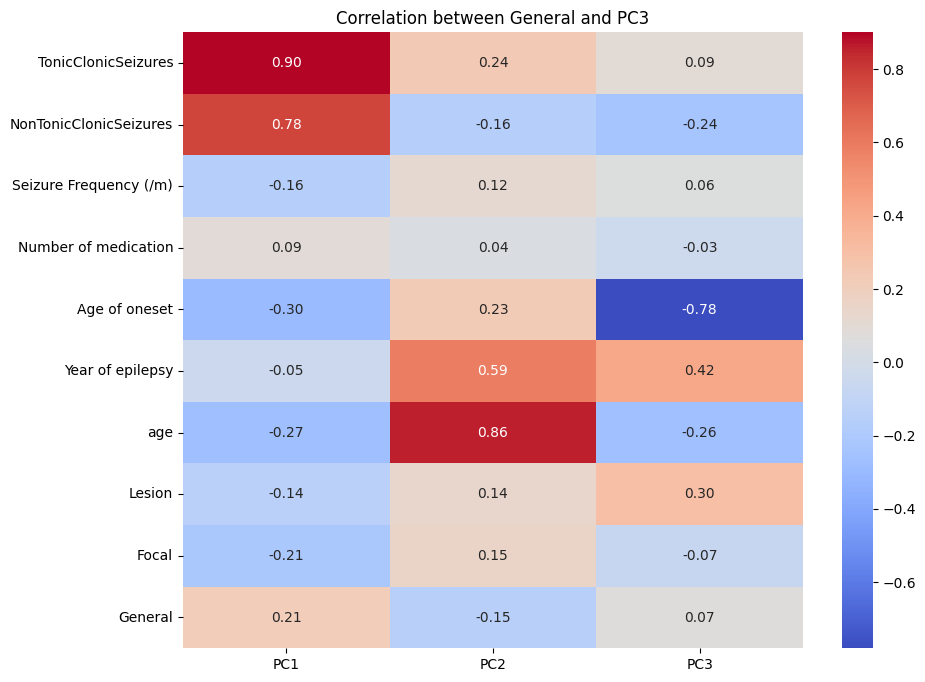

Correlation between PC1 and number of regions: 0.1248018538620388, p-value: 0.38783783318887266
Correlation between PC2 and number of regions: 0.041216316633421596, p-value: 0.7762627149640793
Correlation between PC3 and number of regions: 0.10529856184202813, p-value: 0.4667557403525343


In [6]:
def heatmap_per_component(feature_df):
    # Do PCA target column '# regions with BBBD'
    for n in range(1, 4):
        # Perform PCA with n components
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(feature_df)
        print(f'PCA with {n} components:')
        print('Explained variance ratio:', pca.explained_variance_ratio_)
        # Convert PCA components to DataFrame for easier manipulation
        pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
        # Initialize a DataFrame to store the correlations
        correlation_df = pd.DataFrame(index=feature_df.columns, columns=pca_df.columns)
        
        # Calculate Spearman correlation for each column in df and each column in pca_df
        for column in feature_df.columns:
            for pc in pca_df.columns:
                correlation, _ = spearmanr(feature_df[column], pca_df[pc])
                correlation_df.loc[column, pc] = correlation
        # Convert the correlations to numeric values for plotting
        correlation_df = correlation_df.apply(pd.to_numeric, errors='coerce')
        # sns plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_df, cmap='coolwarm', annot=True, fmt='.2f')
        plt.title(f'Correlation between {column} and {pc}')
        plt.show()
        # Correlation between components and number of regions
        for pc in pca_df.columns:
            correlation, p_value = spearmanr(pca_df[pc], number_of_regions)
            print(f'Correlation between {pc} and number of regions: {correlation}, p-value: {p_value}')
heatmap_per_component(feature_df)

[13:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


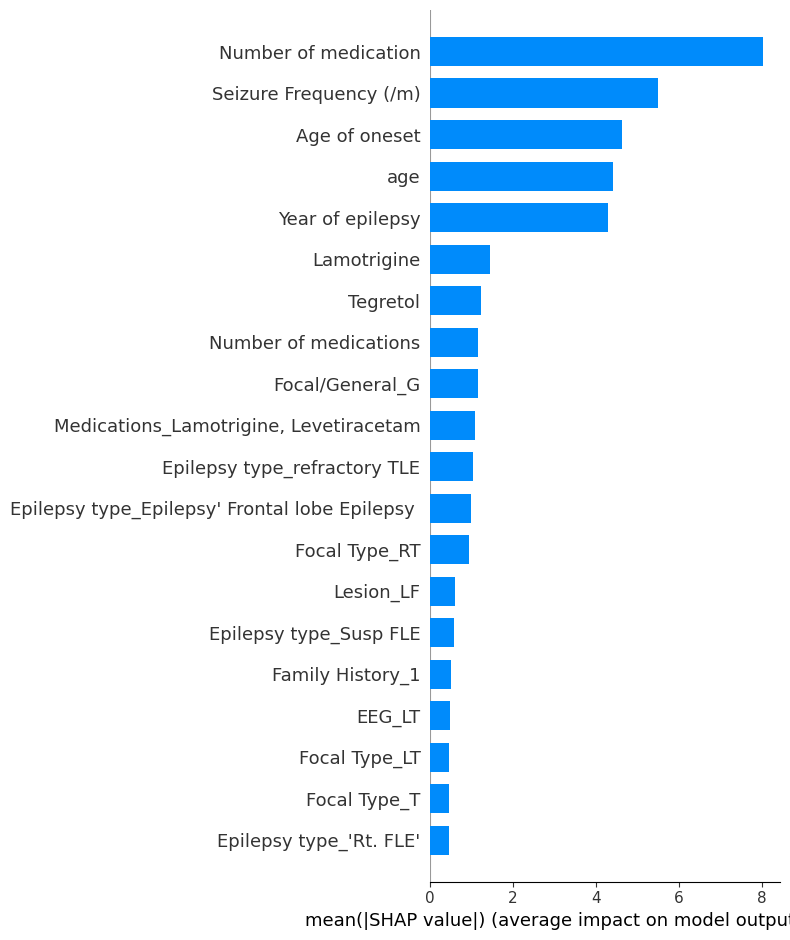

In [5]:
def plot_shap_feature_importance(clinical_data, target_column):
    feature_columns = ['Focal/General', 'Focal Type', 'age', 'gender',
                 'Epilepsy type', 'Seizures type', 'Medications', 'Number of medications', 'Divalproex', 'Tegretol',
                   'Levetiracetam', 'Lamotrigine', 'Divalproex.1', 'Lacosamide', 'Family History', 'Age of oneset', 'Year of epilepsy',
                     'Seizure Frequency (/m)', 'Number of medication','Lesion','EEG']
    feature_data = clinical_data[feature_columns]
    # Splitting the data into features and target
    non_numeric_columns = feature_data.select_dtypes(include=['object', 'category']).columns
    # Apply one-hot encoding to non-numeric columns
    encoded_features = pd.get_dummies(feature_data, columns=non_numeric_columns, drop_first=True)
    # true =1 false =0
    encoded_features = encoded_features.replace({True: 1, False: 0})
    target_data = clinical_data[target_column]
    # y drop na
    target_data = target_data.dropna()
    # x same number of rows as y
    encoded_features = encoded_features.iloc[:len(target_data)]
    # Train a model (XGBoost in this case)
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(encoded_features, target_data)
    # Calculate SHAP values
    shap_explainer = shap.Explainer(xgb_model, encoded_features)
    shap_values = shap_explainer(encoded_features)
    # Plot the SHAP values
    shap.summary_plot(shap_values, encoded_features, plot_type="bar")
    return
plot_shap_feature_importance(clinical_data_df, '# regions with BBBD')

In [26]:

import logging
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import *
from sklearn.neighbors import KNeighborsClassifier
import json
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import numpy as np
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from catboost import *
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn
import pickle
import os
from sklearn.model_selection import GridSearchCV
import json
from ray import tune
# import ray
# import torch
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter("ignore")
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def set_params(x_train, x_test, y_train, y_test,model = None,args= None):
    # model.get_params()
    class_dist = y_train.value_counts().to_dict()
    class_weights = {}
    for c_item in class_dist.items():
        class_weights[c_item[0]] = sum(
            class_dist.values()) / ((x_train.shape[1]) * c_item[1])
    params = {
        'class_weight': class_weights,
    }
    # model.set_params(**params)
    return params

def models_classifiers(x_train, x_test, y_train, y_test):
    models = []
    class_dist = y_train.value_counts().to_dict()
    class_weights = {}
    for c_item in class_dist.items():
        class_weights[c_item[0]] = sum(
            class_dist.values()) / ((x_train.shape[1]) * c_item[1])
    params = set_params(x_train, x_test, y_train, y_test)
    knn = KNeighborsClassifier()
    svc = LinearSVC(**params,multi_class='crammer_singer')
    lr = LogisticRegression(**params)
    dt = DecisionTreeClassifier(**params)
    gnb = GaussianNB()
    rfc = RandomForestClassifier(**params)
    xgb = XGBClassifier(**params)
    gbc = GradientBoostingClassifier()
    ada = AdaBoostClassifier()
    # -------------------------------------------------------------------
    models = []
    models.append(('KNeighborsClassifier', knn))
    models.append(('SVC', svc))
    models.append(('LogisticRegression', lr))
    models.append(('DecisionTreeClassifier', dt))
    models.append(('GaussianNB', gnb))
    models.append(('RandomForestClassifier', rfc))
    models.append(('XGBClassifier', xgb))
    models.append(('GradientBoostingClassifier', gbc))
    models.append(('AdaBoostClassifier', ada))
    models.append(('ExtraTreesClassifier', sklearn.ensemble.ExtraTreesClassifier()))

    models.append(('SGDClassifier', SGDClassifier()))

    models.append(('RidgeClassifier', RidgeClassifier()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('MLPClassifier', MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)))
    # models.append(('catboost', CatBoostClassifier(iterations=5,learning_rate=0.1,)))
    models.append(('xgboost', XGBClassifier( learning_rate=0.1,  n_estimators=100,  max_depth=3,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)))
    models.append(('lightgbm', LGBMClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=-1,
        scale_pos_weight=1,
        seed=27)))
    return models

In [38]:
from sklearn.metrics import mean_absolute_error

def new_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list0 = []
    acc_list1 = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true == i)[0] )
        set_pred = set( np.where(y_pred == i)[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)))
        if i == 0:
            acc_list0.append(tmp_a)
        else:
            acc_list1.append(tmp_a)
    return np.mean(acc_list0), np.mean(acc_list1)

def run_model(name,model,x_train, x_test, y_train, y_test,Model,acc_rmse,cv):
    print('*****************', name, '*******************')
    print('\n')
    try:
        model.fit(np.array(x_train, dtype=float), np.array(y_train, dtype=int))  
    except:
        return Model,RMSE,cv
    print(model)
    pre = model.predict( np.array(x_test,dtype=float))
    print('\n')
    RMSE = r2_score(np.array(y_test, dtype=float), pre)
    print('RMSE   -', RMSE)
    acc_rmse.append(abs(RMSE))
    print('\n')
    sc = cross_val_score(model, x_test, y_test, cv=2, scoring='r2').mean()
    print('cross_val_score  -', sc)
    cv.append(sc)
    Model.append(model)
    return Model,acc_rmse,cv

def ensemble_model(x_train, x_test, y_train, y_test, args = None):
    models = sklearn.utils.all_estimators(type_filter="regressor")
    Model = []
    rmse = []
    r2 = []
    for name, model in models:
        try:
            model = model()
            Model,rmse,r2 = run_model(name,model,x_train, x_test, y_train, y_test,Model,rmse,r2)
        except:
            continue
    print(f'best model r2 {Model[np.nanargmax(r2)]} model: . r2 - {np.nanmax(r2)}. rmse - {rmse[np.nanargmax(r2)]}')
    print(f'best model rmse {Model[np.nanargmin(rmse)]} model: . r2 - {r2[np.nanargmin(rmse)]}. rmse - {np.nanmin(rmse)}')
    # save model to file\
    # pickle.dump(Model[np.argmax(cv)] , open(os.path.join(args['save_models'],
    #     'model_wa_sc'  + '.pickle'), 'wb'))
    return Model[np.nanargmax(cv)]

def run_ensemble_models(clinical_data,target_column):
    feature_columns = ['Focal/General', 'Focal Type', 'age', 'gender',
                'Epilepsy type', 'Seizures type', 'Medications', 'Number of medications', 'Divalproex', 'Tegretol',
                'Levetiracetam', 'Lamotrigine', 'Divalproex.1', 'Lacosamide', 'Family History', 'Age of oneset', 'Year of epilepsy',
                    'Seizure Frequency (/m)', 'Number of medication','Lesion','EEG']
    # clinical_data drop rows all nan
    clinical_data = clinical_data.iloc[:50]
    feature_data = clinical_data[feature_columns]
    # feature_data get only numeric
    feature_data = feature_data.select_dtypes(exclude=['object'])
    feature_data = feature_data.dropna(axis=1, how='all')
    feature_data = feature_data.fillna(feature_data.median())
    target_data = clinical_data[target_column]
    # split test 10% train 90%
    x_train, x_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.1, shuffle=False)
    # split train 80% validation 20%
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    Model = ensemble_model(x_train, x_test, y_train, y_test)
    # get model accuracy on test
    Model,rmse,r2  = run_model([],Model,x_val, x_test, y_val, y_test,[],[],[])
    print(f'best model rmse {Model[np.argmin(rmse)]} model: . r2 - {r2[np.argmin(rmse)]}. rmse - {rmse[np.argmin(rmse)]}')
    pass

run_ensemble_models(clinical_data_df, '# regions with BBBD')

***************** ARDRegression *******************


ARDRegression()


RMSE   - -30.58313241374005


cross_val_score  - -26.180186841907553
***************** AdaBoostRegressor *******************


AdaBoostRegressor()


RMSE   - -55.058068610754965


cross_val_score  - -1.0198412698412698
***************** BaggingRegressor *******************


BaggingRegressor()


RMSE   - -37.267806603773586


cross_val_score  - -1.2360317460317458
***************** BayesianRidge *******************


BayesianRidge()


RMSE   - -60.11038279882096


cross_val_score  - -10.48943383954337
***************** CCA *******************


***************** DecisionTreeRegressor *******************


DecisionTreeRegressor()


RMSE   - -184.27122641509433


cross_val_score  - -5.464285714285714
***************** DummyRegressor *******************


DummyRegressor()


RMSE   - -59.770922504658735


cross_val_score  - -0.7410714285714286
***************** ElasticNet *******************


ElasticNet()


RMSE   - -